# Making a pytorch dataset from Wireless ECoG data
Michael Nolan
2020.07.08

In [32]:
from __future__ import print_function, division
import os
import glob
import torch
import pandas as pd
import json
import pickle as pkl
# from skimage import io, transform
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode


In [8]:
class WirelessEcogDataset(Dataset):
    # Wireless ECoG Dataset
    # Pesaran lab data
    # AOLab
    # Michael Nolan
    # 2020.07.08
    
    def __init__( self, ecog_file, src_len, trg_len, step_len, ch_idx = None):
        ## parse file
        data_file = os.path.basename(ecog_file)
        data_file_kern = os.path.splitext(data_file)[0]
        rec_id, microdrive_name, rec_type = data_file_kern.split('.')
        data_path = os.path.dirname(ecog_file)
        # read experiment file
        exp_file = os.path.join(data_path,rec_id + ".experiment.json")
        with open(exp_file,'r') as f:
            exp_dict = json.load(f)
        # get microdrive parameters
        microdrive_name_list = [md['name'] for md in exp_dict['hardware']['microdrive']]
        microdrive_idx = [md_idx for md_idx, md in enumerate(microdrive_name_list) if microdrive_name == md][0]
        microdrive_dict = exp_dict['hardware']['microdrive'][microdrive_idx]
        n_ch = len(microdrive_dict['electrodes'])
        if not ch_idx:
            ch_idx = np.arange(n_ch)
        # get srate
        if rec_type == 'raw':
            srate = experiment['hardware']['acquisition']['samplingrate']
            data_type = np.ushort
        elif rec_type == 'lfp':
            srate = 1000
            data_type = np.float32
        elif rec_type == 'clfp':
            srate = 1000
            data_type = np.float32
        # read mask
        ecog_mask_file = os.path.join(data_path,data_file_kern + ".mask.pkl")
        with open(ecog_mask_file,"rb") as mask_f:
            mask = pkl.load(mask_f)
        mask = mask["hf"] | mask["sat"]
        # get params
        n_samp = len(mask)
        # create sampling index - src_len+trg_len length segments that don't include a masked sample
        _sample_idx = np.arange(n_samp-(src_len+trg_len),step=step_len)
        _use_sample_idx = np.zeros((len(_sample_idx)),dtype=bool) # all false
        for sidx in range(len(_sample_idx)):
            _use_sample_idx[sidx] = ~np.any(mask[_sample_idx[sidx] + np.arange(src_len+trg_len)])
        sample_idx = _sample_idx[_use_sample_idx]
        
        ## set parameters
        self.file_path = ecog_file
        self.n_ch = n_ch
        self.ch_idx = ch_idx
        self.n_samp = n_samp
        self.sample_idx = sample_idx
        self.data_type = data_type
        self.byte_per_sample = n_ch * data_type().nbytes
        self.src_len = src_len
        self.trg_len = trg_len
        
    def __len__( self ):
        return len(self.sample_idx)
    
    def __getitem__( self, idx ):
        count = (self.src_len + self.trg_len)*self.n_ch
        offset = self.sample_idx[idx]*self.n_ch*self.data_type().nbytes
        data_sample = np.fromfile(self.file_path,dtype=self.data_type,count=count,offset=offset).reshape((self.n_ch,self.src_len+self.trg_len),order='F').T
        src, trg = np.split(data_sample[:,self.ch_idx],[self.src_len])
        
        return src, trg


In [9]:
# test it out!
src_len = 1000
trg_len = 500
step_len = 500
ecog_file = '/Volumes/Samsung_T5/aoLab/Data/WirelessData/Goose_Multiscale_M1/180325/001/rec001.LM1_ECOG_3.clfp.dat'

dataset = WirelessEcogDataset(ecog_file,src_len,trg_len,step_len)

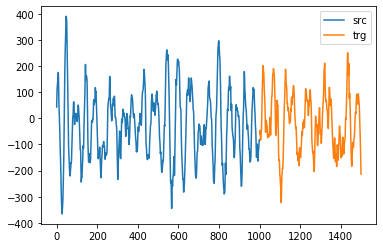

In [10]:
src,trg = dataset.__getitem__(0)
plt.plot(np.arange(dataset.src_len),src[:,0],label='src')
plt.plot(dataset.src_len + np.arange(trg_len),trg[:,0],label='trg')
plt.legend(loc=0)

it works! now let's make a dataloader + sampler for this lil bad boy:

In [11]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
train_p = 0.8
train_idx, valid_idx = np.split(dataset.sample_idx,[np.int(np.floor(train_p*dataset.__len__()))])
train_loader = DataLoader(dataset,sampler=SubsetRandomSampler(train_idx),batch_size=10,shuffle=False)
valid_loader = DataLoader(dataset,sampler=SubsetRandomSampler(valid_idx),batch_size=10,shuffle=False)

### ECoG dataloader across multiple files

In [12]:
class WirelessEcogDataset_MultiFile(Dataset):
    # Wireless ECoG Dataset
    # Pesaran lab data
    # AOLab
    # Michael Nolan
    # 2020.07.08
    
    def __init__( self, ecog_file_list, src_len, trg_len, step_len, ch_idx = None, device='cpu', transform=None ):
        data_parameter_dict = self.create_parameter_dict(ecog_file_list,src_len,trg_len,step_len,ch_idx)
        
        ## set parameters
        self.file_list = ecog_file_list
#         self.n_ch = n_ch
#         self.ch_idx = ch_idx
#         self.n_samp = n_samp
#         self.sample_idx = sample_idx
#         self.data_type = data_type
#         self.byte_per_sample = n_ch * data_type().nbytes
        self.src_len = src_len
        self.trg_len = trg_len
        self.data_parameter_dict = data_parameter_dict
        self.file_ref_idx = np.cumsum([len(x) for x in data_parameter_dict['sample_idx']])
        self.file_offset_idx = np.zeros(self.file_ref_idx.shape,dtype=int)
        self.file_offset_idx[1:] = self.file_ref_idx[:-1]
        self.device = device
        self.transform = transform
        
    def __len__( self ):
        return sum([len(x) for x in self.data_parameter_dict['sample_idx']])
    
    def __getitem__( self, idx, verbose=False ):
        file_idx = np.arange(len(self.file_list))[idx < self.file_ref_idx][0]
        filepath = self.file_list[file_idx]
        in_file_sample_idx = idx - self.file_offset_idx[file_idx]
        dtype = self.data_parameter_dict['data_type'][file_idx]
        n_ch = self.data_parameter_dict['n_ch'][file_idx]
        ch_idx = self.data_parameter_dict['ch_idx'][file_idx]
        count = (self.src_len + self.trg_len)*n_ch
        offset = self.data_parameter_dict['sample_idx'][file_idx][in_file_sample_idx]*n_ch*dtype().nbytes
        data_sample = torch.tensor(np.fromfile(filepath,dtype=dtype,count=count,offset=offset).reshape((n_ch,self.src_len+self.trg_len),order='F').T)
        src, trg = torch.split(data_sample[:,ch_idx],[self.src_len,self.trg_len])
        if self.transform:
            src, trg = self.transform(src, trg)
        
        return src.to(self.device,non_blocking=True), trg.to(self.device, non_blocking=True)
    
    def create_parameter_dict( self, ecog_file_list, src_len, trg_len, step_len, ch_idx=None ):
        n_file = len(ecog_file_list)
        n_samp_list = []
        n_ch_list = []
        srate_list = []
        data_type_list = []
        sample_idx_list = []
        ch_idx_list = []
        for file in ecog_file_list:
            _n_samp, _n_ch, _srate, _data_type, _sample_idx, _ch_idx = self.get_ecog_file_parameters(file,src_len,trg_len,step_len,ch_idx)
            n_samp_list.append(_n_samp)
            n_ch_list.append(_n_ch)
            srate_list.append(_srate)
            data_type_list.append(_data_type)
            sample_idx_list.append(_sample_idx)
            ch_idx_list.append(_ch_idx)
        parameter_dict = {
            'n_samp': n_samp_list,
            'n_ch': n_ch_list,
            'srate': srate_list,
            'data_type': data_type_list,
            'sample_idx': sample_idx_list,
            'ch_idx': ch_idx_list
        }
        return parameter_dict
        
    
    def get_ecog_file_parameters( self, ecog_file, src_len, trg_len, step_len, ch_idx ):
        ## parse file
        data_file = os.path.basename(ecog_file)
        data_file_kern = os.path.splitext(data_file)[0]
        rec_id, microdrive_name, rec_type = data_file_kern.split('.')
        data_path = os.path.dirname(ecog_file)
        # read experiment file
        exp_file = os.path.join(data_path,rec_id + ".experiment.json")
        with open(exp_file,'r') as f:
            exp_dict = json.load(f)
        # get microdrive parameters
        microdrive_name_list = [md['name'] for md in exp_dict['hardware']['microdrive']]
        microdrive_idx = [md_idx for md_idx, md in enumerate(microdrive_name_list) if microdrive_name == md][0]
        microdrive_dict = exp_dict['hardware']['microdrive'][microdrive_idx]
        n_ch = len(microdrive_dict['electrodes'])
        if not ch_idx:
            ch_idx = np.arange(n_ch)
        # get srate
        if rec_type == 'raw':
            srate = experiment['hardware']['acquisition']['samplingrate']
            data_type = np.ushort
        elif rec_type == 'lfp':
            srate = 1000
            data_type = np.float32
        elif rec_type == 'clfp':
            srate = 1000
            data_type = np.float32
        # read mask
        ecog_mask_file = os.path.join(data_path,data_file_kern + ".mask.pkl")
        with open(ecog_mask_file,"rb") as mask_f:
            mask = pkl.load(mask_f)
        mask = mask["hf"] | mask["sat"]
        # get params
        n_samp = len(mask)
        # create sampling index - src_len+trg_len length segments that don't include a masked sample
        _sample_idx = np.arange(n_samp-(src_len+trg_len),step=step_len)
        _use_sample_idx = np.zeros((len(_sample_idx)),dtype=bool) # all false
        for sidx in range(len(_sample_idx)):
            _use_sample_idx[sidx] = ~np.any(mask[_sample_idx[sidx] + np.arange(src_len+trg_len)])
        sample_idx = _sample_idx[_use_sample_idx]
        
        return n_samp, n_ch, srate, data_type, sample_idx, ch_idx


In [13]:
ecog_file_list = glob.glob('/Volumes/Samsung_T5/aoLab/Data/WirelessData/Goose_Multiscale_M1/180325/0*/*.clfp.dat')
ecog_multifile_dataset = WirelessEcogDataset_MultiFile(ecog_file_list,src_len,trg_len,src_len+trg_len)
print(ecog_multifile_dataset)

Text(0.5, 1.0, 'Multifile Dataset - output example')

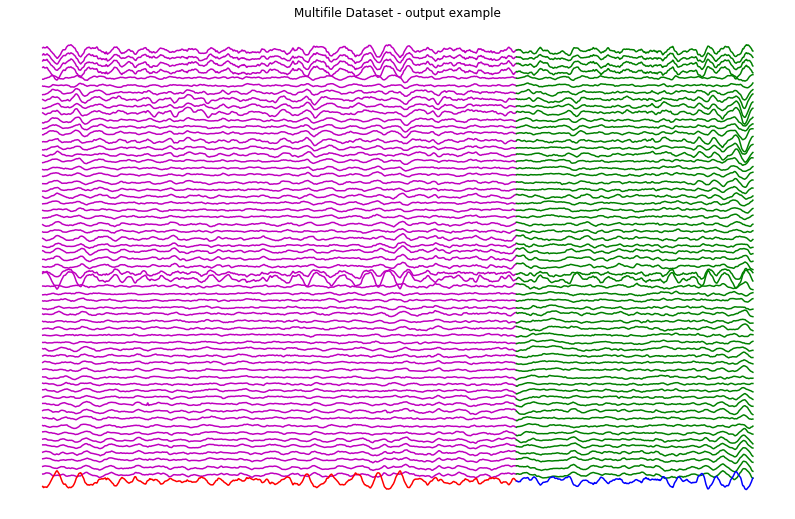

In [14]:
_src, _trg = ecog_multifile_dataset.__getitem__(1)
src = _src - _src.mean(axis=-1)[:,None]
trg = _trg - _trg.mean(axis=-1)[:,None]
plot_ch_idx = 10
spanner = 300
fig,ax = plt.subplots(1,1,figsize=(14,9))
ax.plot(np.arange(src_len),src + spanner*np.arange(src.shape[1]),'m');
ax.plot(np.arange(src_len),_src.mean(axis=-1) - spanner,'r')
ax.plot(src_len+np.arange(trg_len),trg + spanner*np.arange(trg.shape[1]),'g');
ax.plot(src_len+np.arange(trg_len),_trg.mean(axis=-1) - spanner,'b')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off');
ax.set_title('Multifile Dataset - output example')

holy shit - it works! Now let's try the same train/validation loader definitions we made above:

In [15]:
train_p = 0.8
train_idx, valid_idx = np.split(np.arange(ecog_multifile_dataset.__len__()),[np.int(np.floor(train_p*ecog_multifile_dataset.__len__()))])
train_loader = DataLoader(ecog_multifile_dataset,sampler=SubsetRandomSampler(train_idx),batch_size=10,shuffle=False)
valid_loader = DataLoader(ecog_multifile_dataset,sampler=SubsetRandomSampler(valid_idx),batch_size=10,shuffle=False)
print('train loader size: {}'.format(len(train_loader)))
print('validation loader size: {}'.format(len(valid_loader)))

train loader size: 3431
validation loader size: 858


Cool! A multifile dataloader isn't that hard to make, turns out. This should work pretty well for the spectrogram data too, come to think of it.

### Tranforms - normalizing drawn data samples
Any given window should be normalized before passing it into the network. I can think of two different methods for implementing this:
1. z-score the values in the given window based off of mean, variance estimates calculated from the given window
2. z-score the values in the given window using overall file statistics

The second method will require some external preprocessing, so let's take a crack at the first method:

In [16]:
# define the transform class
class local_zscore(object):
    # I do not know if initialization requires more detail in this case.
    def __init__(self):
        None
    
    def __call__(self,src,trg):
        sample = torch.cat([src,trg],dim=0)
        mean = sample.mean(axis=0)
        std = sample.std(axis=0)
        src_z = (src-mean)/std
        trg_z = (trg-mean)/std
        return src_z, trg_z

In [17]:
# recreate the dataset, but specify the transform
transform = local_zscore()
ecog_multifile_dataset = WirelessEcogDataset_MultiFile(ecog_file_list,src_len,trg_len,src_len+trg_len
                                                      ,transform=transform)

Text(0.5, 1.0, 'Normalized Dataset Sample')

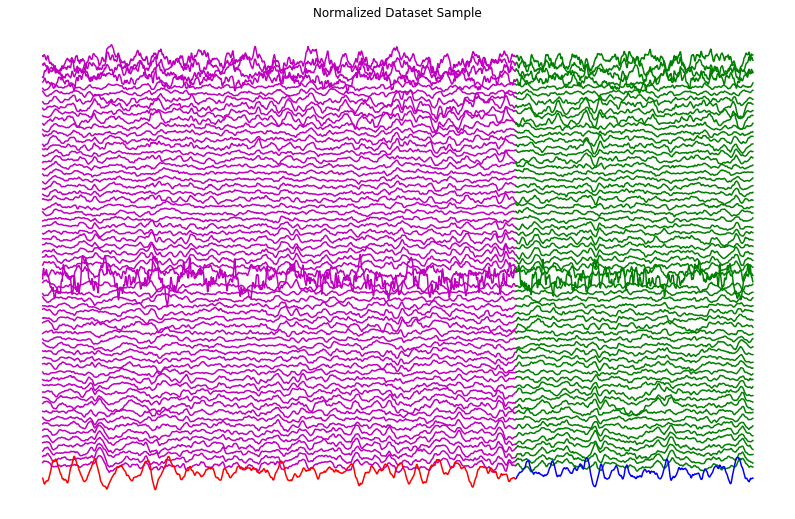

In [18]:
_src, _trg = ecog_multifile_dataset.__getitem__(650)
src = _src - _src.mean(axis=-1)[:,None]
trg = _trg - _trg.mean(axis=-1)[:,None]
plot_ch_idx = 10
spanner = 1
fig,ax = plt.subplots(1,1,figsize=(14,9))
ax.plot(np.arange(src_len),src + spanner*np.arange(src.shape[1]),'m');
ax.plot(np.arange(src_len),_src.mean(axis=-1) - spanner,'r')
ax.plot(src_len+np.arange(trg_len),trg + spanner*np.arange(trg.shape[1]),'g');
ax.plot(src_len+np.arange(trg_len),_trg.mean(axis=-1) - spanner,'b')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off');
ax.set_title('Normalized Dataset Sample')

In [19]:
train_p = 0.8
BATCH_SIZE = 10
train_idx, valid_idx = np.split(np.arange(ecog_multifile_dataset.__len__()),[np.int(np.floor(train_p*ecog_multifile_dataset.__len__()))])
train_loader = DataLoader(ecog_multifile_dataset,sampler=SubsetRandomSampler(train_idx),batch_size=BATCH_SIZE,shuffle=False)
valid_loader = DataLoader(ecog_multifile_dataset,sampler=SubsetRandomSampler(valid_idx),batch_size=BATCH_SIZE,shuffle=False)
print('train loader size: {}'.format(len(train_loader)))
print('validation loader size: {}'.format(len(valid_loader)))

train loader size: 3431
validation loader size: 858


In [20]:
src_batch, trg_batch = next(iter(train_loader))
torch.cat([src_batch,trg_batch],dim=1).mean(axis=1)

tensor([[ 7.6304e-08, -4.8200e-08, -2.8869e-08, -1.1921e-08, -1.1861e-08,
          4.9988e-08, -2.9385e-08,  4.7614e-08, -3.4253e-08, -1.5373e-08,
          1.9670e-09, -7.5897e-09,  7.6075e-08, -5.0947e-08, -6.9042e-09,
         -9.6937e-08,  6.2625e-08,  5.6426e-08,  4.2230e-08,  8.2900e-09,
         -6.0648e-08, -1.9964e-07, -1.0527e-07,  2.1458e-08, -3.4571e-09,
          1.8954e-08, -2.5829e-08,  2.2491e-08,  1.4305e-07, -4.4882e-08,
         -2.8213e-08, -3.0398e-08, -3.1948e-08,  8.6109e-08,  9.9381e-08,
          1.3526e-07, -1.2755e-08, -7.0532e-08,  7.0572e-08, -1.3351e-08,
          2.0862e-09,  1.2318e-09,  3.5107e-08, -2.8570e-08,  3.6160e-09,
          3.8902e-08, -4.2475e-08, -6.7433e-08, -7.7754e-08,  3.8286e-08,
         -4.9472e-08, -1.9646e-07, -5.6128e-08, -3.1590e-08, -3.1233e-08,
         -5.9783e-08,  3.9617e-08,  7.7407e-08,  8.4639e-08,  4.3511e-08,
         -1.1802e-08, -7.5857e-08],
        [-1.5736e-08,  9.8546e-09,  3.9736e-09, -5.9605e-09, -7.6691e-09,
  

good news, bad news: this works like a charm, but it doesn't seem to normalize the data in a way that I want. The dead channels are amplified considerably and will be injecting heaps noise into the network if not culled appropriately. I need to save ch_idx masks into the mask files then incorporate them into the classdef.

Also also also the z-score isn't actually giving me mean-zero values. This should be avoidable!

In [21]:
# profiling:
rand_call = lambda x: ecog_multifile_dataset.__getitem__(random.randint(0,ecog_multifile_data.__len__()-1))
%timeit -n 1000 rand_call
# %timeit -n 1000 next(iter(train_loader))

49.6 ns ± 0.652 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


it even runs pretty quickly! Way to go.

To put the icing on the cake, let's make a function that we can pack into the package that creates the dataset from all available WirelessData files on the current compute platform. That way we can call in the dataset like we're doing the $10^{10}$th algorithm for MNIST classification.

In [24]:
import sys
def spontaneous_ecog( src_len, trg_len, step_len, filter_type='clfp' ):
    platform_name = sys.platform
    if platform_name == 'darwin':
        # local machine
        data_dir_path = '/Volumes/Samsung_T5/aoLab/Data/WirelessData/Goose_Multiscale_M1/180325/'
    elif platform_name == 'linux2':
        # HYAK, baby!
        data_dir_path = '/gscratch/stf/manolan/Data/WirelessData/Goose_Multiscale_M1/180325/'
    elif platform_name == 'linux':
        # google cloud, don't fail me now
        data_file_full_path = '/home/mickey/Data/WirelessData/Goose_Multiscale_M1/180325/'
    # glop the file list
    ecog_file_list = glob.glob(os.path.join(data_dir_path,'0*/*.{}.dat').format(filter_type))
    return WirelessEcogDataset_MultiFile(ecog_file_list,src_len,trg_len,src_len+trg_len,transform=local_zscore())

In [27]:
src_len = 1000
trg_len = 1000
default_ecog_dataset = spontaneous_ecog(src_len,trg_len,src_len+trg_len)

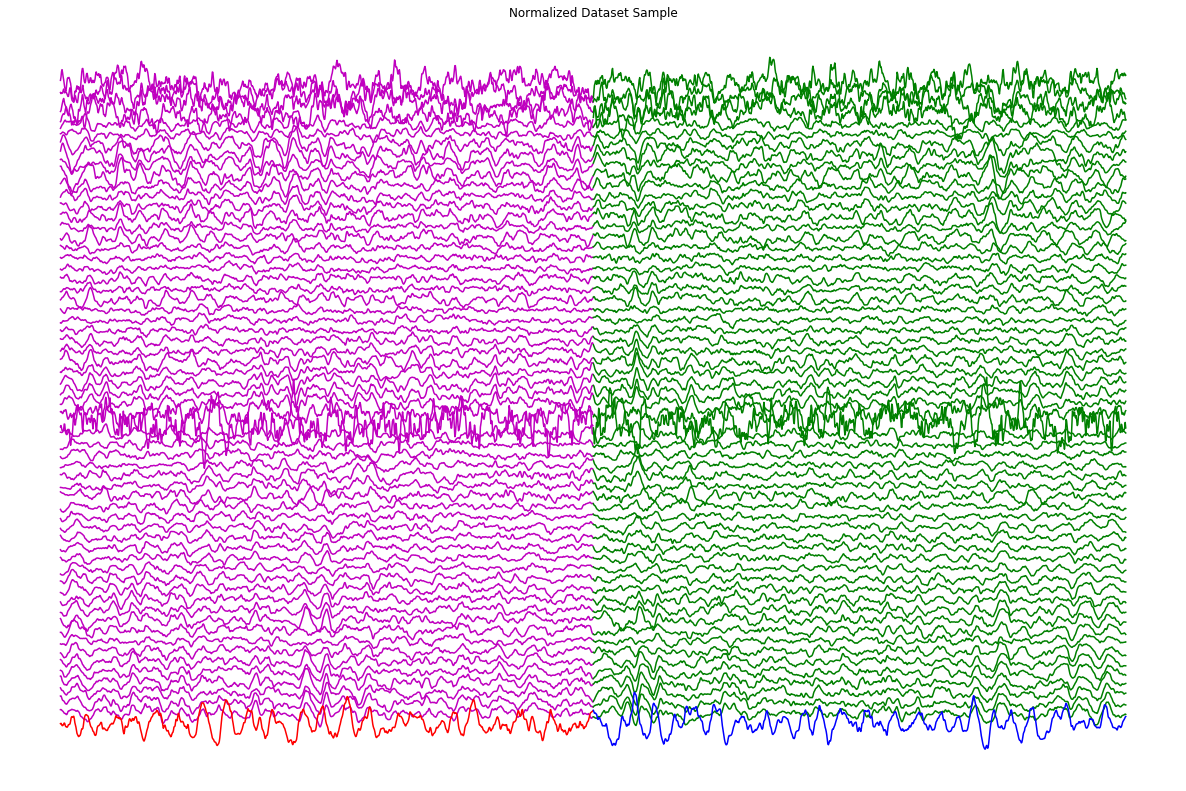

In [37]:
_src, _trg = default_ecog_dataset.__getitem__(650)
src = _src - _src.mean(axis=-1)[:,None]
trg = _trg - _trg.mean(axis=-1)[:,None]
plot_ch_idx = 10
spanner = 1
fig,ax = plt.subplots(1,1,figsize=(21,14))
ax.plot(np.arange(src_len),src + spanner*np.arange(src.shape[1]),'m');
ax.plot(np.arange(src_len),_src.mean(axis=-1) - spanner,'r')
ax.plot(src_len+np.arange(trg_len),trg + spanner*np.arange(trg.shape[1]),'g');
ax.plot(src_len+np.arange(trg_len),_trg.mean(axis=-1) - spanner,'b')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off');
ax.set_title('Normalized Dataset Sample')
fig.show()